# Deep learning the collisional cross sections of the peptide universe from a million experimental values

Florian Meier, Niklas D. Köhler, Andreas-David Brunner, Jean-Marc H. Wanka, Eugenia Voytik, Maximilian T. Strauss, Fabian J. Theis, Matthias Mann

Pre-print: https://doi.org/10.1101/2020.05.19.102285  
Publication: pending

revised 09/2020

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
import glob

from numba import jit, prange, autojit, njit
import time
import scipy.cluster.hierarchy as shc
import scipy.spatial.distance as ssd
import scipy.spatial as spatial

from scipy import stats

In [2]:
@njit
def mean_dist_pairwise(matrix, shape):
    dist = np.zeros((shape,shape))
    
    for i in prange(shape):
        for j in prange(shape):
            dist[j,i] = np.nanmean(matrix[:,i] - matrix[:,j])
    
    return dist   

In [3]:
def overlap_pairwise(matrix, shape):
    dist = np.zeros((shape,shape))
    
    for i in prange(shape):
        for j in prange(shape):
            x = matrix[:,i]
            y = matrix[:,j]
            
            mask = ~np.logical_or(np.isnan(x), np.isnan(y))   
            
            dist[j,i] = mask.sum()
                
    return dist

In [4]:
def pearson_pairwise(matrix, shape, minpoints):
    dist = np.zeros((shape,shape))
    
    for i in prange(shape):
        for j in prange(shape):
            x = matrix[:,i]
            y = matrix[:,j]
            
            mask = ~np.logical_or(np.isnan(x), np.isnan(y))           
            
            if(mask.sum() > minpoints):
                dist[j,i] = stats.pearsonr(np.compress(mask, x), np.compress(mask, y))[0]
            else:
                dist[j,i] = np.nan
    
    return dist    

#### Import raw data from MaxQuant output

In [64]:
# Load evidence.txt files from folder
filenames = glob.glob("data/evidence*.txt")
evidences = [pd.read_csv(filename, sep='\t', engine='python', header=0) for filename in filenames]

# Combine all evidences in one dataframe
evidence_all = pd.concat(evidences, sort=False, ignore_index = True)

# Clean up 
del evidences

evidence_all.head()

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages (Trypsin/P),Missed cleavages (LysN),...,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs,Missed cleavages,Unnamed: 0,1/K0
0,AAAAAAAEAAAAAEAAAAAAAEAAAEQK,28,Unmodified,_AAAAAAAEAAAAAEAAAAAAAEAAAEQK_,NaN,NaN,0,0,0.0,1.0,...,66,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAEAAAAAEAAAAAAAEAAAEQK,28,Unmodified,_AAAAAAAEAAAAAEAAAAAAAEAAAEQK_,NaN,NaN,0,0,0.0,1.0,...,66,0,0,1,1,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAEAAASTTNGEANGVQESAATESK,30,Unmodified,_AAAAAAAEAAASTTNGEANGVQESAATESK_,NaN,NaN,0,0,0.0,1.0,...,4253,1,1,2,2,NaN,NaN,NaN,NaN,NaN
3,AAAADAAGDAADNGTSK,17,Unmodified,_AAAADAAGDAADNGTSK_,NaN,NaN,0,0,0.0,1.0,...,5600,2,2,3,3,NaN,NaN,NaN,NaN,NaN
4,AAAADAAGDAADNGTSK,17,Unmodified,_AAAADAAGDAADNGTSK_,NaN,NaN,0,0,0.0,1.0,...,5600,2,2,4,4,NaN,NaN,NaN,NaN,NaN


In [65]:
# Drop reverse hits
# Drop features with no intensity value
# Drop charge 1 features

evidence_all = evidence_all.loc[(evidence_all['Reverse'] != '+') & (evidence_all['Intensity'] > 0) & (evidence_all['Charge'] != 1)]

### Evaluating the precision and utility of TIMS CCS measurements

In [7]:
# Select tryptic subset

selection = ['HeLa_Trypsin_1', 'HeLa_Trp_2', 'Drosophila_Trp', 'Yeast_Trypsin', 'Ecoli_trypsin', 'CElegans_Tryp']
evidence_tryptic = evidence_all.loc[evidence_all['Experiment'].isin(selection)]

len(set(evidence_tryptic['Raw file']))

168

In [8]:
del evidence_all # free memory

In [9]:
# CCS values
# Keep only one evidence per raw file

# Maximum intensity
selection = ['Modified sequence', 'Sequence', 'Charge', 'Mass', 'm/z', 'CCS', 'Experiment', 'id', 'Intensity', 'Score', 'Length', 'Raw file']
evidence_agg = evidence_tryptic.loc[evidence_tryptic.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()][selection]

evidence_pivot_tryptic_long_CCS = evidence_agg.pivot_table(index = ['Modified sequence', 'Charge'], 
                                          columns = 'Raw file', 
                                          values = 'CCS')
del evidence_agg 

evidence_pivot_tryptic_long_CCS = evidence_pivot_tryptic_long_CCS.astype(np.float32)

len(evidence_tryptic), len(evidence_pivot_tryptic_long_CCS)

(1612353, 382165)

In [66]:
# RT values
# Keep only one evidence per raw file

# Maximum intensity
selection = ['Modified sequence', 'Sequence', 'Charge', 'Mass', 'm/z', 'CCS', 'Retention time', 'Experiment', 'id', 'Intensity', 'Score', 'Length', 'Raw file']
evidence_agg = evidence_tryptic.loc[evidence_tryptic.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()][selection]

evidence_pivot_tryptic_long_RT = evidence_agg.pivot_table(index = ['Modified sequence', 'Charge'], 
                                          columns = 'Raw file', 
                                          values = 'Retention time')
del evidence_agg 

evidence_pivot_tryptic_long_RT = evidence_pivot_tryptic_long_RT.astype(np.float32)

len(evidence_tryptic), len(evidence_pivot_tryptic_long_RT)

(1612353, 382165)

In [143]:
evidence_pivot_tryptic_long_RT.iloc[:,0:48].columns

Index(['20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_10_B8_01_2600',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_11_C8_01_2601',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_12_D8_01_2602',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_13_E8_01_2603',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_14_F8_01_2604',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_15_G8_01_2605',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_16_H8_01_2606',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_17_A9_01_2607',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_18_B9_01_2608',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_19_C9_01_2609',
       '20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50c

In [141]:
evidence_pivot_tryptic_long_RT.iloc[:,144:168].columns

Index(['20190504_TIMS1_FlMe_SA_HeLa_frac01_A10_1_93',
       '20190504_TIMS1_FlMe_SA_HeLa_frac02_B10_1_94',
       '20190504_TIMS1_FlMe_SA_HeLa_frac03_C10_1_95',
       '20190504_TIMS1_FlMe_SA_HeLa_frac04_D10_1_96',
       '20190504_TIMS1_FlMe_SA_HeLa_frac05_E10_1_97',
       '20190504_TIMS1_FlMe_SA_HeLa_frac06_F10_1_98',
       '20190504_TIMS1_FlMe_SA_HeLa_frac07_G10_1_99',
       '20190504_TIMS1_FlMe_SA_HeLa_frac08_H10_1_126',
       '20190504_TIMS1_FlMe_SA_HeLa_frac09_A11_1_101',
       '20190504_TIMS1_FlMe_SA_HeLa_frac10_B11_1_102',
       '20190504_TIMS1_FlMe_SA_HeLa_frac11_C11_1_103',
       '20190504_TIMS1_FlMe_SA_HeLa_frac12_D11_1_104',
       '20190504_TIMS1_FlMe_SA_HeLa_frac13_E11_1_105',
       '20190504_TIMS1_FlMe_SA_HeLa_frac14_F11_1_106',
       '20190504_TIMS1_FlMe_SA_HeLa_frac15_G11_1_107',
       '20190504_TIMS1_FlMe_SA_HeLa_frac16_H11_1_108',
       '20190504_TIMS1_FlMe_SA_HeLa_frac17_A12_1_109',
       '20190504_TIMS1_FlMe_SA_HeLa_frac18_B12_1_110',
       '20190504_

In [11]:
# Filter out peptides with only one occurence to speed up and save memory 

evidence_pivot_tryptic_CCS = evidence_pivot_tryptic_long_CCS.loc[evidence_pivot_tryptic_long_CCS.isnull().sum(axis=1) < (len(set(evidence_tryptic['Raw file'])) - 1)]
evidence_pivot_tryptic_RT = evidence_pivot_tryptic_long_RT.loc[evidence_pivot_tryptic_long_RT.isnull().sum(axis=1) < (len(set(evidence_tryptic['Raw file'])) - 1)]

len(evidence_pivot_tryptic_CCS), len(evidence_pivot_tryptic_long_CCS)

(236156, 382165)

In [68]:
# Calculate pairwise Pearson correlation for retention time values
# requires > 4 shared data points for calculation

start = time.time()
evidence_tryptic_pearson_RT = pd.DataFrame(pearson_pairwise(np.array(evidence_pivot_tryptic_RT), evidence_pivot_tryptic_RT.shape[1], 4))
end = time.time()

print((end - start)/60)

0.27118695179621377


In [69]:
# Calculate pairwise Pearson correlation for CCS values
# requires > 4 shared data points for calculation

start = time.time()
evidence_tryptic_pearson_CCS = pd.DataFrame(pearson_pairwise(np.array(evidence_pivot_tryptic_CCS), evidence_pivot_tryptic_CCS.shape[1], 4))
end = time.time()

print((end - start)/60)

0.27241737047831216


In [70]:
# Calculate pairwise overlap

start = time.time()
evidence_tryptic_overlap = pd.DataFrame(overlap_pairwise(np.array(evidence_pivot_tryptic_RT), evidence_pivot_tryptic_RT.shape[1]))
end = time.time()

print((end - start)/60)

0.19942511717478434


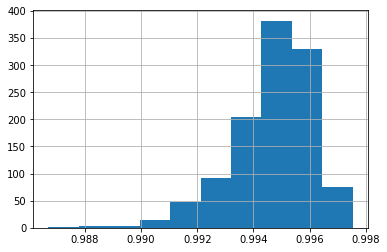

In [182]:
evidence_tryptic_pearson_CCS.iloc[0:48, 144:168].unstack().hist();

In [178]:
# Pearson correlation (CCS) of the two HeLa data sets
np.round((evidence_tryptic_pearson_CCS.iloc[0:48, 144:168]).unstack().median(), 3)

0.995

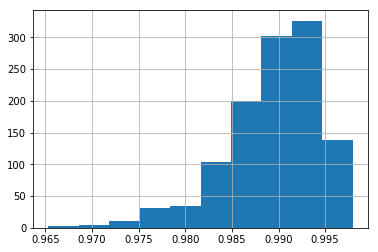

In [183]:
evidence_tryptic_pearson_RT.iloc[0:48, 144:168].unstack().hist();

In [179]:
# Pearson correlation (retention time) of the two HeLa data sets
np.round((evidence_tryptic_pearson_RT.iloc[0:48, 144:168]).unstack().median(), 3)

0.99

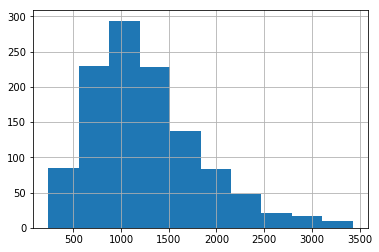

In [184]:
evidence_tryptic_overlap.iloc[0:48, 144:168].unstack().hist();

In [162]:
# Pearson correlation (retention time) of the two HeLa data sets
np.round(evidence_tryptic_overlap.iloc[0:48, 144:168].unstack().mean())

1264.0

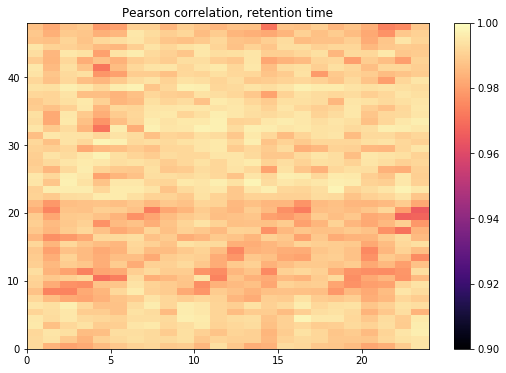

In [163]:
plt.figure(figsize=(9,6))
plt.title('Pearson correlation, retention time')
plt.pcolor(evidence_tryptic_pearson_RT.iloc[0:48, 144:168], cmap='magma', vmin=0.9, vmax=1)
plt.colorbar()

plt.show()

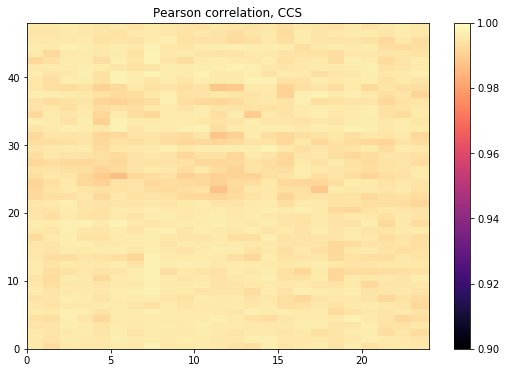

In [164]:
plt.figure(figsize=(9,6))
plt.title('Pearson correlation, CCS')
plt.pcolor(evidence_tryptic_pearson_CCS.iloc[0:48, 144:168], cmap='magma', vmin=0.9, vmax=1)
plt.colorbar()

plt.show()

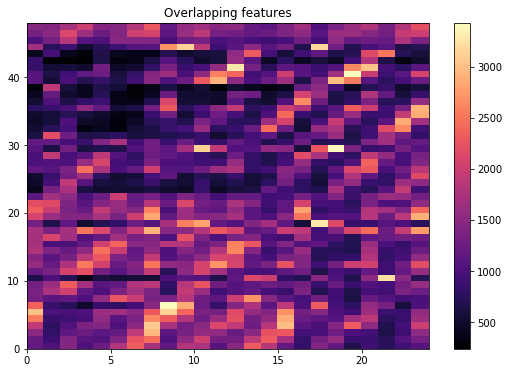

In [185]:
plt.figure(figsize=(9,6))
plt.title('Overlapping features')
plt.pcolor(evidence_tryptic_overlap.iloc[0:48, 144:168], cmap='magma')
plt.colorbar()

plt.show()

In [13]:
# keep only triagonal matrix for figure

evidence_tryptic_pearson_RT = evidence_tryptic_pearson_RT.mask(np.arange(len(evidence_tryptic_pearson_RT))[:,None] <= np.arange(len(evidence_tryptic_pearson_RT)))
evidence_tryptic_pearson_CCS = evidence_tryptic_pearson_CCS.mask(np.arange(len(evidence_tryptic_pearson_CCS))[:,None] >= np.arange(len(evidence_tryptic_pearson_CCS)))

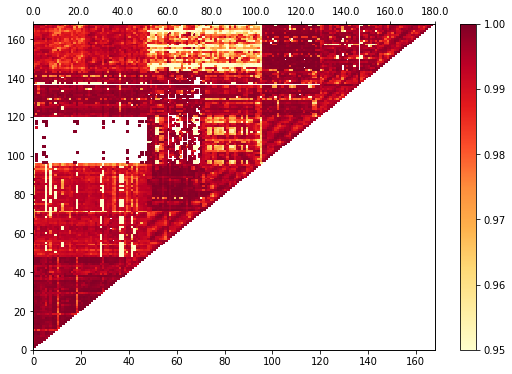

In [14]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.pcolor(evidence_tryptic_pearson_RT, cmap='YlOrRd', vmin=0.95, vmax=1)

ax2 = ax1.twiny()
X2tick_location= ax1.xaxis.get_ticklocs()
ax2.set_xticks(X2tick_location)
ax2.set_xticklabels(X2tick_location)

plt.colorbar()

plt.savefig("figures/Figure_2_a_rt.pdf");
plt.show()

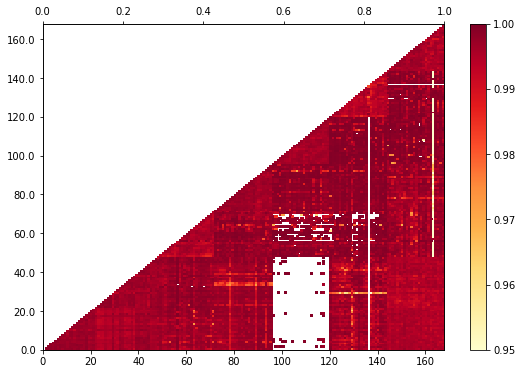

In [15]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.pcolor(evidence_tryptic_pearson_CCS, cmap='YlOrRd', vmin=0.95, vmax=1)

ax3 = ax1.twiny()
X2tick_location= ax1.yaxis.get_ticklocs()
ax3.set_yticks(X2tick_location)
ax3.set_yticklabels(X2tick_location)

plt.colorbar()

plt.savefig("figures/Figure_2_a_ccs.pdf");

<b>Figure 2. Precision, accuracy and utility of experimental peptide CCS values.</b> a, Color-coded pairwise Pearson correlation values of peptide retention time (upper triangular matrix) and CCS values (lower triangular matrix) between 168 LC-MS/MS runs of fractionated tryptic digests. Experimental meta-data are indicated below the x-axis. White (n/a) indicates less than 5 data points for pairwise comparison.

In [45]:
start = time.time()
evidence_tryptic_distance_CCS = pd.DataFrame(mean_dist_pairwise(np.array(evidence_pivot_tryptic_CCS), evidence_pivot_tryptic_CCS.shape[1]))
end = time.time()

print((end - start)/60)

0.09535953601201376


In [51]:
# make triangular matrix
evidence_tryptic_distance_CCS = evidence_tryptic_distance_CCS.mask(np.arange(len(evidence_tryptic_distance_CCS))[:,None] <= np.arange(len(evidence_tryptic_distance_CCS)))

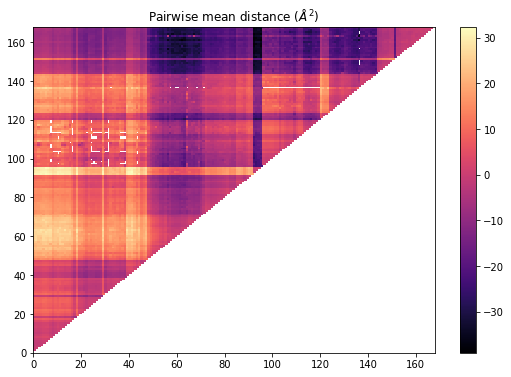

In [54]:
plt.figure(figsize=(9,6))
plt.title('Pairwise mean distance ($\AA^2$)')
plt.pcolor(evidence_tryptic_distance_CCS, cmap='magma')
plt.colorbar()

plt.show()

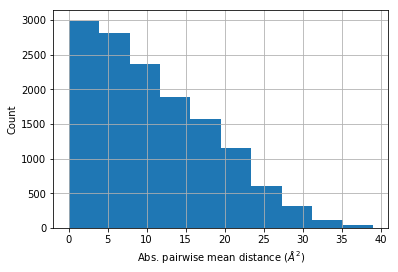

In [60]:
evidence_tryptic_distance_CCS.unstack().abs().hist()
plt.ylabel('Count')
plt.xlabel('Abs. pairwise mean distance ($\AA^2$)');

In [61]:
print("Max. abs. distance: {:.1f} Å^2".format(evidence_tryptic_distance_CCS.unstack().abs().max()))
print("Median abs. distance: {:.1f} Å^2".format(evidence_tryptic_distance_CCS.unstack().abs().median()))

Max. abs. distance: 39.0 Å^2
Median abs. distance: 9.4 Å^2


#### Import aligned dataset

In [62]:
evidence_pivot_aligned = pd.read_csv('output/evidence_pivot_aligned.csv')
evidence_pivot_aligned.head()

,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_10_B8_01_2600,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_11_C8_01_2601,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_12_D8_01_2602,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_13_E8_01_2603,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_14_F8_01_2604,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_15_G8_01_2605,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_16_H8_01_2606,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_17_A9_01_2607,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_18_B9_01_2608,20180631_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_100ms_11CT_120min_Fraction_19_C9_01_2609,...,20190504_TIMS1_FlMe_SA_HeLa_frac15_G11_1_107,20190504_TIMS1_FlMe_SA_HeLa_frac16_H11_1_108,20190504_TIMS1_FlMe_SA_HeLa_frac17_A12_1_109,20190504_TIMS1_FlMe_SA_HeLa_frac18_B12_1_110,20190504_TIMS1_FlMe_SA_HeLa_frac19_C12_1_111,20190504_TIMS1_FlMe_SA_HeLa_frac20_D12_1_112,20190504_TIMS1_FlMe_SA_HeLa_frac21_E12_1_113,20190504_TIMS1_FlMe_SA_HeLa_frac22_F12_1_114,20190504_TIMS1_FlMe_SA_HeLa_frac23_G12_1_115,20190504_TIMS1_FlMe_SA_HeLa_frac24_H12_1_116
0,NaN,NaN,NaN,NaN,NaN,NaN,410.59674,NaN,NaN,NaN,...,NaN,405.0256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,574.0613,NaN,NaN,NaN,NaN,NaN,NaN,575.7866,576.4134,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,621.7289,622.3560,NaN


In [66]:
# Exclude Proteome Tools data
proteometools = set(evidence_all.loc[evidence_all['Experiment'].isin(['Proteotypic', 'SRMATLAS', 'MissingGeneSet'])]['Raw file'])

evidence_pivot_aligned_endo = evidence_pivot_aligned.drop(proteometools, axis = 1)

len(evidence_pivot_aligned.columns), len(evidence_pivot_aligned_endo.columns)

(747, 360)

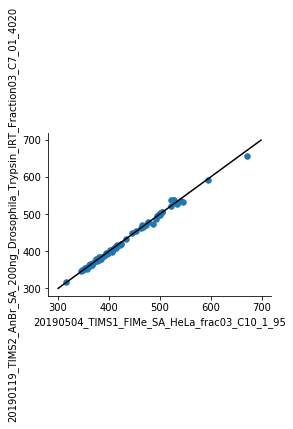

In [71]:
runs = ['20190504_TIMS1_FlMe_SA_HeLa_frac03_C10_1_95', '20190119_TIMS2_AnBr_SA_200ng_Drosophila_Trypsin_IRT_Fraction03_C7_01_4020']

x = evidence_pivot_aligned[runs[0]]
y = evidence_pivot_aligned[runs[1]]

mask = ~np.logical_or(np.isnan(x), np.isnan(y))  
pcorr = stats.pearsonr(np.compress(mask, x), np.compress(mask, y))[0]

fig = plt.figure(figsize=(4,3))
ax = plt.axes()

plt.scatter(x, y, s = 30, alpha = 1)
plt.xlabel(runs[0])
plt.ylabel(runs[1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(np.arange(300,700,1), np.arange(300,700,1), color = 'black')

plt.savefig("figures/Figure_2_b.pdf");
plt.show()

In [84]:
print("n = {0}".format(mask.sum()))
print("Pearson correlation: {:1.3f}".format(pcorr))
print("Median delta = {:1.2f}%".format(np.nanmedian((x-y)/y*100)))
print("Median absolute delta = {:1.2f}%".format(np.nanmedian(np.abs((x-y)/y*100))))

n = 68
Pearson correlation: 0.998
Median delta = 0.19%
Median absolute delta = 0.71%


In [67]:
# Calculate coefficients of variation
evidence_pivot_aligned_endo_CV = evidence_pivot_aligned_endo.std(axis = 1, skipna = True) / evidence_pivot_aligned_endo.mean(axis = 1, skipna = True) * 100

In [68]:
print("Median relative standard deviation: {:10.2f}%".format(evidence_pivot_aligned_endo_CV.dropna().median()))
print("Unique sequences*charge with >1 measurements: {}".format(len(evidence_pivot_aligned_endo_CV.dropna())))

Median relative standard deviation:       0.43%
Unique sequences*charge with >1 measurements: 347885


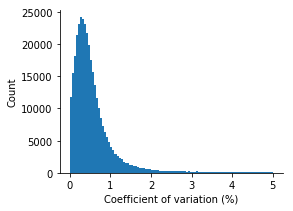

In [70]:
fig = plt.figure(figsize=(4,3))

ax = plt.axes()

plt.hist(x = evidence_pivot_aligned_endo_CV.dropna(), bins = 100, range = (0,5))

plt.xlabel('Coefficient of variation (%)')
plt.ylabel('Count')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("figures/Figure_2_c.pdf");
plt.show()

In [87]:
def kdtree_worker(mass_tolerance, ccs_tolerance, masses, crossections):
    found_points = []
    results = []
    tolerance = 0.1

    points = np.array([np.log(masses)/mass_tolerance*1e6*tolerance, np.log(crossections)/ccs_tolerance*1e2*tolerance]).T

    point_tree = spatial.cKDTree(points)

    for i, point in enumerate(points):

        n_found = point_tree.query_ball_point(point, tolerance, p=np.float('inf'))

        results.append(len(n_found)-1)

    ratio_kd = np.sum(np.array(results)>0)/len(results)
    
    return ratio_kd

In [120]:
def kdtree_worker_count(mass_tolerance, ccs_tolerance, masses, crossections):
    found_points = []
    results = []
    tolerance = 0.1

    points = np.array([np.log(masses)/mass_tolerance*1e6*tolerance, np.log(crossections)/ccs_tolerance*1e2*tolerance]).T

    point_tree = spatial.cKDTree(points)

    for i, point in enumerate(points):

        n_found = point_tree.query_ball_point(point, tolerance, p=np.float('inf'))

        results.append(len(n_found))
    
    return results

In [88]:
cmap = plt.get_cmap("RdYlBu")
colors = cmap(np.linspace(0, 1, num=20))

In [165]:
evidence_aligned = pd.read_csv('output/evidence_aligned.csv')
evidence_aligned.head()

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time,CCS
0,_(ac)AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,HeLa_Trp_2,9,149810.0,162.800,16,70.140,409.092528
1,_(ac)AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR_,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,3,3144.55482,1049.192220,HeLa_Trypsin_1,124,194000.0,71.438,39,3947.700,772.098100
2,_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,AAAAAAAGDSDSWDADAFSVEDPVRK,2,2634.18340,1318.098980,HeLa_Trp_2,26,6416400.0,111.750,26,94.079,573.213220
3,_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,AAAAAAAGDSDSWDADAFSVEDPVRK,3,2634.18340,879.068411,HeLa_Trp_2,30,5400600.0,42.218,26,94.841,635.000577
4,_(ac)AAAAAAAGDSDSWDADAFSVEDPVR_,AAAAAAAGDSDSWDADAFSVEDPVR,2,2506.08844,1254.051500,HeLa_Trp_2,23,245720.0,135.890,25,104.620,547.559190


In [166]:
# Select peptides with N-terminal R or K

evidence_aligned['lastAA'] = evidence_aligned['Sequence'].str[-1:]
evidence_tryptic = evidence_aligned.loc[(evidence_aligned['lastAA'] == 'R') | (evidence_aligned['lastAA'] == 'K')]

len(evidence_aligned), len(evidence_tryptic)

(559979, 452592)

In [167]:
# Split by charge state

evidence_tryptic_cs2 = evidence_tryptic.loc[evidence_tryptic['Charge'] == 2]
evidence_tryptic_cs3 = evidence_tryptic.loc[evidence_tryptic['Charge'] == 3]
                                            
len(evidence_tryptic_cs2), len(evidence_tryptic_cs3)                                            

(324246, 112015)

In [171]:
set(evidence_aligned['Experiment'])

{'CElegans_Tryp',
 'Drosophila_LysC',
 'Drosophila_LysN',
 'Drosophila_Trp',
 'Ecoli_LysC',
 'Ecoli_LysN',
 'Ecoli_trypsin',
 'HeLa_LysC',
 'HeLa_LysN',
 'HeLa_Trp_2',
 'HeLa_Trypsin_1',
 'Yeast_LysC',
 'Yeast_LysN',
 'Yeast_Trypsin'}

In [94]:
# Calculate interference ratios for charge state 2

CCS_tolerances =  [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3, 5, 10, 20, 50]
mass_tolerances = [1.5]  
    
evaluation_cs2 = []
for ccs_tolerance in CCS_tolerances:     
    for mass_tolerance in mass_tolerances:
            ratio = kdtree_worker(mass_tolerance, ccs_tolerance, evidence_tryptic_cs2['m/z'], evidence_tryptic_cs2['CCS'])
            evaluation_cs2.append((mass_tolerance, ccs_tolerance, ratio))

In [95]:
# Results, charge state 2
out2 = pd.DataFrame(evaluation_cs2)
out2.columns = ['Mass Tolerance', 'CCS Tolerance', 'Interference Ratio']
out2

,Mass Tolerance,CCS Tolerance,Interference Ratio
0,1.5,0.1,0.137985
1,1.5,0.2,0.239602
2,1.5,0.3,0.319646
3,1.5,0.5,0.434766
4,1.5,0.7,0.516466
5,1.5,1.0,0.600732
6,1.5,1.5,0.691074
7,1.5,2.0,0.748389
8,1.5,3.0,0.813978
9,1.5,5.0,0.868572


In [96]:
CCS_tolerances =  [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3, 5, 10, 20, 50]
mass_tolerances = [1.5]  
    
evaluation_cs3 = []
for ccs_tolerance in CCS_tolerances:     
    for mass_tolerance in mass_tolerances:
            ratio = kdtree_worker(mass_tolerance, ccs_tolerance, evidence_tryptic_cs3['m/z'], evidence_tryptic_cs3['CCS'])
            evaluation_cs3.append((mass_tolerance, ccs_tolerance, ratio))

In [97]:
# Results, charge state 3
out3 = pd.DataFrame(evaluation_cs3)
out3.columns = ['Mass Tolerance', 'CCS Tolerance', 'Interference Ratio']
out3

,Mass Tolerance,CCS Tolerance,Interference Ratio
0,1.5,0.1,0.020060
1,1.5,0.2,0.040057
2,1.5,0.3,0.058662
3,1.5,0.5,0.094362
4,1.5,0.7,0.127947
5,1.5,1.0,0.174334
6,1.5,1.5,0.241182
7,1.5,2.0,0.297951
8,1.5,3.0,0.386011
9,1.5,5.0,0.499665


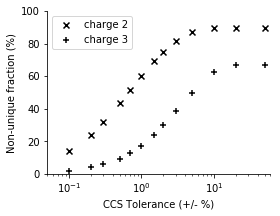

In [98]:
fig = plt.figure(figsize=(4,3))

ax = plt.axes()

plt.scatter(out2['CCS Tolerance'], out2['Interference Ratio']*100, marker = 'x', label = 'charge 2', color = 'black')
plt.scatter(out3['CCS Tolerance'], out3['Interference Ratio']*100, marker = '+', label = 'charge 3', color = 'black')


plt.xlabel('CCS Tolerance (+/- %)')
plt.ylabel('Non-unique fraction (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim((0,100))
plt.xlim((0.05,60))
plt.xscale('log')

plt.legend()

plt.savefig("figures/Figure_2_d.pdf");
plt.show()

### Candidate peptide sequences in a given window

In [184]:
CCS_tolerances =  [0.5, 1.5, 100]
mass_tolerances = [1.5]  

In [185]:
evaluation = []
for ccs_tolerance in CCS_tolerances:     
    for mass_tolerance in mass_tolerances:
            candidates = kdtree_worker_count(mass_tolerance, ccs_tolerance, evidence_tryptic_cs2['m/z'], evidence_tryptic_cs2['CCS'])
            evaluation.append((mass_tolerance, ccs_tolerance, candidates))

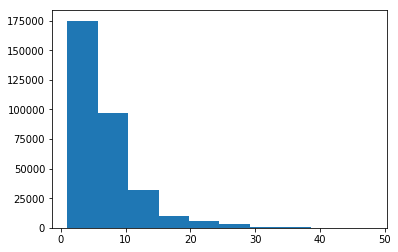

In [189]:
# no ion mobility
plt.hist(evaluation[2][2]);

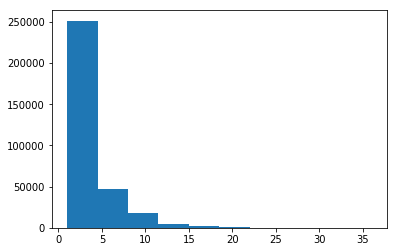

In [188]:
# 1.5% mobility deviation

plt.hist(evaluation[1][2]);

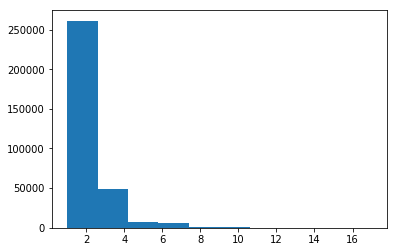

In [190]:
# 0.5% mobility deviation

plt.hist(evaluation[0][2]);

In [191]:
# Median number of doubly charged peptides in a +- 1.5 ppm x [0.5%, 1.5%, 100%] window
np.median(evaluation[0][2]), np.median(evaluation[1][2]), np.median(evaluation[2][2])

(1.0, 2.0, 5.0)

In [192]:
evaluation = []
for ccs_tolerance in CCS_tolerances:     
    for mass_tolerance in mass_tolerances:
            candidates = kdtree_worker_count(mass_tolerance, ccs_tolerance, evidence_tryptic_cs3['m/z'], evidence_tryptic_cs3['CCS'])
            evaluation.append((mass_tolerance, ccs_tolerance, candidates))

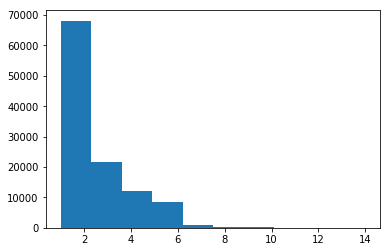

In [193]:
# no ion mobility
plt.hist(evaluation[2][2]);

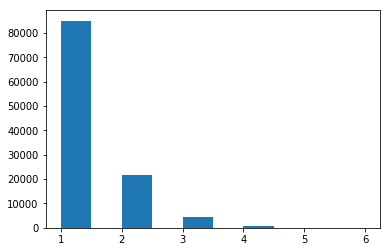

In [194]:
# 1.5% mobility deviation

plt.hist(evaluation[1][2]);

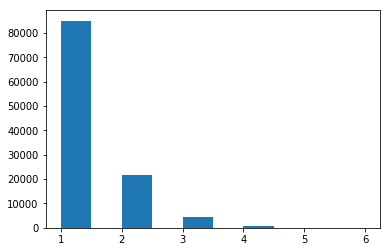

In [195]:
# 0.5% mobility deviation

plt.hist(evaluation[1][2]);

In [196]:
# Median number of triply charged peptides in a +- 1.5 ppm x [0.5%, 1.5%, 100%] window
np.median(evaluation[0][2]), np.median(evaluation[1][2]), np.median(evaluation[2][2])

(1.0, 1.0, 2.0)